## Notes and resources

https://quantum.cloud.ibm.com/ = dashboard for the IBM Quantum Cloud


Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later with visualization support (`pip install `)
* Qiskit Runtime 0.22 or later (`pip install `)


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2


## Setup


In [3]:
# RUN THIS ONLY ONCE
# from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
# import json
# crn = open("crn", "r").read()
# # load json dict apikey.json
# api_key = json.load(open("apikey.json"))["apikey"]
# QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token=api_key, instance=crn, overwrite=True)

In [ ]:
# Qiskit imports
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit.transpiler import Layout

# tutorial at https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/error-correction-repetition-code.ipynb
from mldec.hardware.topological_codes.circuits import RepetitionCode
from mldec.hardware.topological_codes.fitters import GraphDecoder, lookuptable_decoding

# circuit wrappers and optimizers
from mldec.hardware.topological_codes.noise import get_noise

### Setting up simulations and backwards compatibility of decoders.

In [5]:
def get_raw_results(code,noise_model=None, shots=10):
    """this is purely for backwards compatibility with the topological_codes decoders.
    For future experiments, I should make the data structures more array-based"""

    noisy_sampler = AerSampler(
        options=dict(backend_options=dict(noise_model=noise_model))
    )

    circuits = code.get_circuit_list()
    job = noisy_sampler.run(circuits, shots=shots)
    results = job.result()
    # convert the distinct measurement results into a single string, to be compatible with the topolotical_codes decoders.
    out = {}
    for i, result in enumerate(results):
        raw_results = {}
        data = result.data
        all_meas_all_rounds = [getattr(data, f"round_{j}_link_bit_0").get_bitstrings() for j in range(T)]
        final_code_meas = getattr(data, f"code_bit_0").get_bitstrings()
        for k in range(shots):
            combined = final_code_meas[k] + " " + " ".join([all_meas_all_rounds[j][k] for j in range(T)])
            raw_results[combined] = raw_results.get(combined, 0) + 1
        out[str(i)] = raw_results
        
    return out


n = 5
T = 2
code = RepetitionCode(n, T)


noise_model = get_noise(0.05, 0.05)
# noise_model = None
raw_results = get_raw_results(code, noise_model=noise_model, shots=2048)
for log in raw_results:
    print(f'Logical {log}: {raw_results[log]}\n')

Logical 0: {'00000 0000 0000': 459, '01000 0001 0001': 6, '00011 0000 0001': 2, '10100 0010 1010': 1, '00010 0000 0000': 37, '00000 1000 1000': 43, '01001 0000 0001': 1, '00000 0100 0000': 3, '00000 1000 0100': 1, '00100 0010 1100': 1, '10100 1000 0010': 1, '10100 0000 0000': 2, '00010 0000 1000': 3, '00000 0100 0100': 60, '01010 0100 1010': 1, '00100 0100 0000': 3, '00001 0100 0100': 6, '00100 0100 0010': 1, '00001 0000 0000': 46, '00000 0000 0010': 56, '00001 1000 1100': 1, '00000 0010 0010': 53, '10000 0010 1010': 3, '00000 0000 1000': 58, '00100 0010 0100': 18, '00000 0001 0001': 49, '01000 0110 1010': 5, '00010 0001 0010': 13, '00100 0000 1001': 2, '00000 0000 0001': 57, '00000 0000 1010': 6, '01000 0101 1001': 1, '00000 0101 0101': 6, '00001 0000 1000': 6, '00010 0000 0001': 14, '00001 0010 0100': 1, '01000 0000 0000': 40, '00010 0000 0010': 4, '00000 0000 0100': 52, '01001 0000 1101': 1, '10110 0000 0110': 3, '01000 0001 0101': 2, '00001 0010 0011': 2, '00000 0100 0111': 2, '010

In [128]:
# # build a lookup table (careful, this is really slow.)
# table_results = get_raw_results(code, noise_model=noise_model, shots=10000)
# print(table_results)
# P = lookuptable_decoding(raw_results, table_results)
# print('P =', P)

In [6]:
results = code.process_results(raw_results)

# processed_results format: [initial logical obs], [final logical obs], [t=1 detectors], ..., [t=T detectors]
for log in ['0', '1']:
    print(f'\nLogical {log}:')
    print('raw results       ', {string:raw_results[log][string] for string in raw_results[log] if raw_results[log][string]>=25 })
    print('processed results ', {string:results[log][string] for string in results[log] if results[log][string]>=25 })


Logical 0:
raw results        {'00000 0000 0000': 459, '00010 0000 0000': 37, '00000 1000 1000': 43, '00000 0100 0100': 60, '00001 0000 0000': 46, '00000 0000 0010': 56, '00000 0010 0010': 53, '00000 0000 1000': 58, '00000 0001 0001': 49, '00000 0000 0001': 57, '01000 0000 0000': 40, '00000 0000 0100': 52, '10000 0000 0000': 45, '00100 0000 0000': 39}
processed results  {'0 0  0000 0000 0000': 459, '0 0  0000 0000 0011': 37, '0 0  1000 1000 0000': 43, '0 0  0100 0100 0000': 60, '0 1  0000 0000 0001': 46, '0 0  0010 0000 0010': 56, '0 0  0010 0010 0000': 53, '0 0  1000 0000 1000': 58, '0 0  0001 0001 0000': 49, '0 0  0001 0000 0001': 57, '0 0  0000 0000 1100': 40, '0 0  0100 0000 0100': 52, '1 0  0000 0000 1000': 45, '0 0  0000 0000 0110': 39}

Logical 1:
raw results        {'11111 0100 0100': 53, '11111 0000 0000': 431, '11101 0000 0000': 30, '11111 0000 0010': 33, '11111 1000 1000': 51, '11111 0001 0001': 48, '01111 0000 0000': 38, '11111 0000 1000': 50, '10111 0000 0000': 35, '11110

### Set up hardware job submission

NOTES:
 - I think it makes sense to do the delays with two specs: (1) delay by a fraction $\beta$ of the following gate's length, (2) delay the physical ``compiled'' gates, not the logical ones. Aha! This makes even more sense with the virtual Z's, which I'd forgotten about.
  - think about: the delays are staggering the circuit in some ways, especially since they're done post-transpilation. maybe its cleaner to do this with barriers around the measurements? These are the dominant delays after all..
  - Delays also don't make as much sense for measurements: in these cases, a delay will pretty strongly bias the measurement towards a decay into $|0\rangle$.
  - FIXME: I can't align the delays correctly, because the qiskit circuit isn't stored in a nice way

In [7]:
service = QiskitRuntimeService()
backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=5
)
print("backend: ", backend)

backend:  <IBMBackend('ibm_torino')>


In [40]:
# assign qubits to specific physical qubits in the pattern code-link-code-link-code
def make_layout(code, target_qubits):
    qc = code.circuit['1'] # same as using code.circuit['0']
    qregs_links = qc.qregs[0]
    qregs_code = qc.qregs[1]
    assert len(target_qubits) == len(qregs_code) + len(qregs_links)

    mapping_dict = {}
    code_targets = target_qubits[::2]
    link_targets = target_qubits[1::2]
    mapping_dict.update(zip(code_targets, qregs_code))
    mapping_dict.update(zip(link_targets, qregs_links))
    layout = Layout(input_dict=mapping_dict)
    return layout


In [ ]:


# Set scheduling stage to custom pass manager


In [111]:
from qiskit.transpiler.passes import ALAPScheduleAnalysis
from qiskit.transpiler import PassManager

# DEBUG
n = 3
T = 1
code = RepetitionCode(n, T, barriers=True)
sampler = Sampler(mode=backend)

if n == 3:
    target_qubits = [4, 16, 23, 24, 25]
elif n == 5:
    target_qubits = [5, 6, 7, 8, 9, 10, 11, 12, 13]
    
layout = make_layout(code, target_qubits)

first_pm = generate_preset_pass_manager(
    optimization_level=1, backend=backend, 
    layout_method='trivial', routing_method='none', 
    initial_layout=layout,
    )

# FIXME: can't figure out how to schedule delays ALAP...
# scheduling_pm = PassManager([ALAPScheduleAnalysis(target=backend.target)])

# second_pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
# second_pm.scheduling = scheduling_pm

In [113]:
from mldec.hardware.topological_codes.wrappers import insert_idle_delays_dag


### RUN THE JOB ###
# create a list of the circuit with a different wait time insertion
delay_factors = [2, 5, 10]
training_circuits = []
for delay_factor in delay_factors:
    # we will have alternating logical 0 and logical 1 experiments
    for logical in ['0', '1']:
        isa_circuit = first_pm.run(code.circuit[logical])
        isa_circuit_delayed = insert_idle_delays_dag(isa_circuit, delay_factor=delay_factor, backend=backend)
        training_circuits.append(isa_circuit_delayed)

training_job = sampler.run(training_circuits, shots=2048)
print("training_job.job_id(): ", training_job.job_id())

validation_circuits = []
for logical in ['0', '1']:
    isa_circuit = first_pm.run(code.circuit[logical])
    validation_circuits.append(isa_circuit)
validation_job = sampler.run(validation_circuits, shots=2048)
print("validation job id:", validation_job.job_id())


[QuantumRegister(133, 'q')]


global phase: π
                                                                                                                                                                                                                                 
                 q_0: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                 
                 q_1: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                 
                 q_2: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                 
                 q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                       ░  ░ ┌───────────────┐                                                                                                                      ░                          ░  ░  ░ ┌────────────────┐┌─┐      
                 q_4: ─░──░─┤ Delay(20[dt]) ├───────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────░──────────────────────────░──░──░─┤ Delay(390[dt]) ├┤M├──────
                       ░  ░ └───────────────┘                                                   │                                                                  ░                          ░  ░  ░ └────────────────┘└╥┘      
                 q_5: ──────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                │                                                                                                                        ║       
                 q_6: ──────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                │                                                                                                                        ║       
                 q_7: ──────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                │                                                                                                                        ║       
                 q_8: ──────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────

[QuantumRegister(133, 'q')]


global phase: π
                                                                                                                                                                                                                                                         
                 q_0: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                         
                 q_1: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                         
                 q_2: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                         
                 q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                       ░ ┌──────────────┐┌───┐ ░  ░ ┌───────────────┐                                                                                                                      ░                          ░  ░  ░ ┌────────────────┐┌─┐      
                 q_4: ─░─┤ Delay(8[dt]) ├┤ X ├─░──░─┤ Delay(20[dt]) ├───────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────░──────────────────────────░──░──░─┤ Delay(390[dt]) ├┤M├──────
                       ░ └──────────────┘└───┘ ░  ░ └───────────────┘                                                   │                                                                  ░                          ░  ░  ░ └────────────────┘└╥┘      
                 q_5: ──────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                                        │                                                                                                                        ║       
                 q_6: ──────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                                        │                                                                                                                        ║       
                 q_7: ──────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[QuantumRegister(133, 'q')]


global phase: π
                                                                                                                                                                                                                                      
                 q_0: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                      
                 q_1: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                      
                 q_2: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                      
                 q_3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                       ░  ░ ┌───────────────┐                                                                                                                         ░                           ░  ░  ░ ┌─────────────────┐┌─┐      
                 q_4: ─░──░─┤ Delay(80[dt]) ├────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────░───────────────────────────░──░──░─┤ Delay(1560[dt]) ├┤M├──────
                       ░  ░ └───────────────┘                                                    │                                                                    ░                           ░  ░  ░ └─────────────────┘└╥┘      
                 q_5: ───────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                 │                                                                                                                            ║       
                 q_6: ───────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                 │                                                                                                                            ║       
                 q_7: ───────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                 │                                                                                                                            ║       
                 q_8: ───────────────────────────────────

[QuantumRegister(133, 'q')]


global phase: π
                                                                                                                                                                                                                                                               
                 q_0: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                               
                 q_1: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                               
                 q_2: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                               
                 q_3: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                       ░ ┌───────────────┐┌───┐ ░  ░ ┌───────────────┐                                                                                                                         ░                           ░  ░  ░ ┌─────────────────┐┌─┐      
                 q_4: ─░─┤ Delay(32[dt]) ├┤ X ├─░──░─┤ Delay(80[dt]) ├────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────░───────────────────────────░──░──░─┤ Delay(1560[dt]) ├┤M├──────
                       ░ └───────────────┘└───┘ ░  ░ └───────────────┘                                                    │                                                                    ░                           ░  ░  ░ └─────────────────┘└╥┘      
                 q_5: ────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                                          │                                                                                                                            ║       
                 q_6: ────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                                          │                                                                                                                            ║       
                 q_7: ────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────

[QuantumRegister(133, 'q')]


global phase: π
                                                                                                                                                                                                                                        
                 q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                        
                 q_1: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                        
                 q_2: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                        
                 q_3: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                       ░  ░ ┌────────────────┐                                                                                                                          ░                           ░  ░  ░ ┌─────────────────┐┌─┐      
                 q_4: ─░──░─┤ Delay(180[dt]) ├─────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────░───────────────────────────░──░──░─┤ Delay(3510[dt]) ├┤M├──────
                       ░  ░ └────────────────┘                                                     │                                                                    ░                           ░  ░  ░ └─────────────────┘└╥┘      
                 q_5: ─────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                   │                                                                                                                            ║       
                 q_6: ─────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                   │                                                                                                                            ║       
                 q_7: ─────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                   │                                                                                                                            ║       
                 q_8: ─

[QuantumRegister(133, 'q')]


global phase: π
                                                                                                                                                                                                                                                                 
                 q_0: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                 
                 q_1: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                 
                 q_2: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                 
                 q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                       ░ ┌───────────────┐┌───┐ ░  ░ ┌────────────────┐                                                                                                                          ░                           ░  ░  ░ ┌─────────────────┐┌─┐      
                 q_4: ─░─┤ Delay(72[dt]) ├┤ X ├─░──░─┤ Delay(180[dt]) ├─────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────░───────────────────────────░──░──░─┤ Delay(3510[dt]) ├┤M├──────
                       ░ └───────────────┘└───┘ ░  ░ └────────────────┘                                                     │                                                                    ░                           ░  ░  ░ └─────────────────┘└╥┘      
                 q_5: ──────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                                            │                                                                                                                            ║       
                 q_6: ──────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───────
                                                                                                                            │                                                                                                                            ║       
                 q_7: ────────────────────────────────────────────────────────────────────────────────────────────

training_job.job_id():  d1dmmq5qbivc73eacsbg
validation job id: d1dmmqaq8ogc73erbb1g


In [ ]:
isa_circuit_delayed = insert_idle_delays_dag(isa_circuit, delay_factor=2, backend=backend)
isa_circuit_delayed.draw(output='text', fold=500)

c:\Users\peter\Desktop\projects\mldec\.venv\Lib\site-packages\qiskit\circuit\quantumcircuit.py:3800: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


global phase: π
                                                                                                                                                                                                                                                                                                                
                 q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                
                 q_1: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                
                 q_2: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                
                 q_3: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                       ░ ┌──────────────┐┌───┐ ░  ░                                             ┌────────────────┐                                                                     ░                                              ░  ░  ░ ┌─────────────────┐                                      ┌─┐      
                 q_4: ─░─┤ Delay(8[dt]) ├┤ X ├─░──░─────────────────────────────────────────────┤0               ├─■───────────────────────────────────────────────────────────────────░──────────────────────────────────────────────░──░──░─┤0                ├──────────────────────────────────────┤M├──────
                       ░ └──────────────┘└───┘ ░  ░                                             │                │ │                                                                   ░                                              ░  ░  ░ │                 │                                      └╥┘      
                 q_5: ──────────────────────────────────────────────────────────────────────────┤                ├─┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤                 ├───────────────────────────────────────╫───────
                                                                                                │                │ │                                                                                                                          │                 │                                       ║       
                 q_

In [30]:
from qiskit.converters import circuit_to_dag
dag = circuit_to_dag(isa_circuit_delayed)


for node in dag.topological_op_nodes():
    print(node)


2060939399296
2060937444880
2060937437968
2060937443296
2060937443872
2060937441424
2061558159024
2060944481936
2060944481648
2060944488704
2060944477328
2060944482800
2060944482656
2060944482944
2060944479920
2060944489424
2060944483376
2060944489136
2060944483808
2060944484240
2060944483952
2060944484384
2060944484816
2060944483664
2060944484528
2060944484960
2060944485392
2060944483520
2060944485104
2060944485536
2060944484672
2060944484096
2060944486112
2060944485968
2060944485248
2060944487984
2060944485680
2060944486544
2060944486256
2060944485824
2060944486688
2060944487264
2060944487120
2060944488128
2060944486400
2060944486832
2060944487552
2060944488416
2060944487696
2060944487408
2060944489280


In [ ]:
# current running jobs: wait times 0, 100, ..., 1000 with a logical '1' prepared.
# To get counts for a particular pub result, use
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register.
# You can use circuit.cregs to find the name of the classical registers.

In [72]:
service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/00676e59ecdd4175be3cc729886ac91a:3d11824a-45a9-46fa-ac02-c700f961f10c::'
)
job = service.job('d1a6lqemm8oc73a07l50')
job_result = job.result()


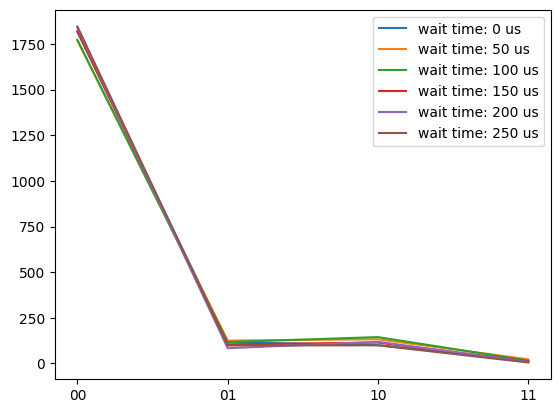

In [78]:
xvals = ['00', '01', '10', '11']
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(job_result)):
    us = us_wait_times[i]
    counts = job_result[i].data.round_0_link_bit_0.get_counts()
    ax.plot(xvals, [counts.get(x, 0) for x in xvals], label=f"wait time: {us} us")
ax.legend()
# ax.semilogy()
plt.show()


In [25]:
# get job results for first test runs
service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/00676e59ecdd4175be3cc729886ac91a:3d11824a-45a9-46fa-ac02-c700f961f10c::'
)

# without wait gates:
job = service.job('d19m0c04nhtc73abin60')
job_result = job.result()
# with wait gates:
job_idle = service.job('d19m0c96rndc73faasig')
job_idle_result = job_idle.result()


In [26]:
print(job_result[0].data.round_0_link_bit_0.get_counts())
print(job_idle_result[0].data.round_0_link_bit_0.get_counts())



{'00': 974, '10': 21, '01': 5}
{'00': 926, '01': 47, '10': 23, '11': 4}


In [ ]:
pub_result = job_result[0].data.<classical register>.get_counts()

# To get counts for a particular pub result, use
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register.
# You can use circuit.cregs to find the name of the classical registers.

In [146]:
job_idle.status()
result = job_idle.result()

'QUEUED'

In [ ]:

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]



# print(qc.draw(output='text'))

# qc_idle = 
# print(qc_idle.draw(output='text'))

In [ ]:
def get_raw_results(code,noise_model=None, shots=10):

    noisy_sampler = Sampler(
        options=dict(backend_options=dict(noise_model=noise_model))
    )

    circuits = code.get_circuit_list()
    job = noisy_sampler.run(circuits, shots=shots)
    results = job.result()
    # convert the distinct measurement results into a single string, to be compatible with the topolotical_codes decoders.
    out = {}
    for i, result in enumerate(results):
        raw_results = {}
        data = result.data
        all_meas_all_rounds = [getattr(data, f"round_{j}_link_bit_0").get_bitstrings() for j in range(T)]
        final_code_meas = getattr(data, f"code_bit_0").get_bitstrings()
        for k in range(shots):
            combined = final_code_meas[k] + " " + " ".join([all_meas_all_rounds[j][k] for j in range(T)])
            raw_results[combined] = raw_results.get(combined, 0) + 1
        out[str(i)] = raw_results
        
    return out

In [63]:
noise_model = get_noise(0.05, 0.05)
raw_results = get_raw_results(code, noise_model=noise_model)
for i, result in enumerate(raw_results):
    data = result.data
    print(f"logical |{i}>")
    for j in range(T): # each round has one set of parity measurements
        print(f"round {j}: ", getattr(data, f"round_{j}_link_bit_0").get_counts())
    print("final measurements")
    print(getattr(data, f"code_bit_0").get_counts())
    print()

logical |0>
round 0:  {'00': 8, '01': 1, '11': 1}
round 1:  {'11': 4, '00': 6}
final measurements
{'110': 2, '000': 7, '010': 1}

logical |1>
round 0:  {'10': 3, '00': 7}
round 1:  {'10': 3, '00': 4, '01': 3}
final measurements
{'111': 5, '011': 1, '101': 3, '000': 1}

